In [1]:
import numpy as np
import pandas as pd
import joblib
import re
from collections import Counter
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 200)
pd.set_option('display.width', 1000)

tipo_renovacion = 'LapseFull'
#############################################################################################

if tipo_renovacion == 'LapseFull':
    df = pd.read_excel('data/Loyalty_dataset_v4.xlsx', 'Última Poliza', engine='openpyxl')
    df = df.drop(['LapseMid'], axis=1)
elif tipo_renovacion == 'LapseMid':
    df = pd.read_excel('data/Loyalty_dataset_v4.xlsx', 'dataset_v4', engine='openpyxl')
    df = df.drop(['LapseFull'], axis=1)

tipo_poliza_map = {
    'BIC': 'OFF Shore',
    'BINS': 'OFF Shore',
}

df['tipo_poliza'] = df.CoverEntity.map(tipo_poliza_map)
df['tipo_poliza'].fillna('ON Shore', inplace=True)

# Remove not useful variables
df = df.drop(["Renewal", 'CoverageFromDate', 'CoverageThruDate', 'PolicyYear', 'Orden', 
                'GuarianAge', 'UnknownCount', 'Unknown1', 'Unknown2', 'Unknown3', 
                'Unknown4', 'Unknown5', 'Unknown6', 'Unknown7', 'Unknown8', 'Unknown9'], axis=1)
df

,PH_ContactBaseID,PolicyMonth,BillingFreq,PlanKey,RegionKey,CoverEntity,CoverProduct,CoverPlan,ProductGroup,RiskCountry,RateClassL0,RateClassL1,Duration,Members,FamilyStructure,OwnerAge,SpouseAge,DependentsCountLT23,DependentsCountAT23,LapseFull,PremiumCalculator,PremiumIn,PremiumOut,PremiumOutConstant,RenewedAT23,flagAlcoholMisuse,flagAsthma,flagAtrialFibrillation,flagCancerLymphoma,flagCancerMetastatic,flagCancerNonMetastatic,flagChronicHeartFailure,flagChronicKidneyDisease,flagChronicPain,flagChronicPulmonaryDisease,flagChronicViralHepatitis,flagCirrhosis,flagDementia,flagDepression,flagDiabetes,flagEpilepsy,flagHypertension,flagHypothyroidism,flagInflammatoryBowel,flagIrritableBowel,flagMultipleSclerosis,flagMyocardialInfarction,flagParkinsons,flagPepticUlcer,flagPeripheralVascular,flagPsoriasis,flagRheumatoidArthritis,flagSchizophrenia,flagSevereConstipation,flagStroke,RateIncrease,RateIncreasePortfolio,RateIncreaseAge,PaidClaims,IncurredClaims,CountClaims,DenialsL12,DeadEndFlag,TransferBupaMexico,TransferBupaEcuador,TransferBupaDR,TransferBupaBolivia,TransferBupaPanama,TransferBupaGuatemala,SuccessorsFoundDiffNumber,tipo_poliza
0,251795,2,Annual,AMP_E4V,AMP_Region Venezuela,BIC,Amedex Worldwide,Plan E,Mid,Venezuela,Amedex Worldwide,Venezuela,20,2,Married,62,58.0,0,0,0,Normal,9386,10051,10051,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.070850,0.070850,0.000000,0.000,0.000000,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,OFF Shore
1,251797,2,Annual,AMP_E4V,AMP_Region Venezuela,BIC,Amedex Worldwide,Plan E,Mid,Venezuela,Amedex Worldwide,Venezuela,19,1,Single,32,NaN,0,0,1,Normal,1871,2121,2121,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.133618,0.133618,0.000000,0.000,0.000000,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,OFF Shore
2,251798,2,Annual,AMP_E4V,AMP_Region Venezuela,BIC,Amedex Worldwide,Plan E,Mid,Venezuela,Amedex Worldwide,Venezuela,19,1,Single,29,NaN,0,0,1,Normal,1651,2121,1873,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.284676,0.134464,0.132408,0.000,0.000000,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,OFF Shore
3,251806,1,Semi-Annual,AMP_ET63,AMP_Region 3 Bupa,BIC,Bupa Care Essential,Plan 6,Low,El Salvador,Bupa Care Offshore,Region 3,20,2,Married,57,57.0,0,0,0,Normal,8158,9232,9232,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.131650,0.131650,0.000000,4199.998,4285.712245,29,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,OFF Shore
4,251809,1,Semi-Annual,AMP_ET63,AMP_Region 3 Bupa,BIC,Bupa Care Essential,Plan 6,Low,El Salvador,Bupa Care Offshore,Region 3,20,1,Single,25,NaN,0,0,1,Normal,1837,2083,2083,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.133914,0.133914,0.000000,0.000,0.000000,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,OFF Shore
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59577,1284554,2,Quarterly,AMP_AW41,AMP_Region 1 Bupa,BIC,Bupa Care Advantage,Plan 4,Mid,Mexico,Bupa Care Offshore,Region 1,12,1,Single,95,NaN,0,0,0,Normal,46338,50745,50745,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.095106,0.095106,0.000000,0.000,0.000000,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,OFF Shore
59578,1286869,2,Semi-Annual,AMP_BGSG4,AMP_Guatemala Company,Bupa Guatemala,Bupa Global Select,Plan 4,Global Props,Guatemala,No Region,No Region,3,1,Single,69,NaN,0,0,0,Normal,9137,11429,10508,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.250848,0.150049,0.087648,0.000,0.000000,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,ON Shore
59579,1288285,3,Annual,AMP_CR56,AMP_Region 6 Bupa,BIC,Bupa Care Critical,Plan 5,Critical,Colombia,Bupa Care Offshore,Region 6,4,1,Single,30,NaN,0,0,1,Critical,820,955,955,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.164634,0.164634,0.000000,0.000,0.000000,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,OFF Shore
59580,12892

In [2]:
disease_cols = [col for col in df.columns if col.startswith('flag')]

# New features
df['TotalDiseases'] = df[disease_cols].sum(axis=1)
df['Premiun_diff'] = df.PremiumOut - df.PremiumIn

In [127]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

tipo_poliza = 'OFF Shore'
model_df = df.query(f'tipo_poliza == "{tipo_poliza}"')

onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
# One-hot encoding for categorical variables
x1=pd.get_dummies(model_df["BillingFreq"])
model_df = pd.concat([model_df, x1], axis=1)

x2=pd.get_dummies(model_df["ProductGroup"])
#x2.rename(columns={'Critical': 'ProductGroup_Critical'}, inplace= True)
model_df = pd.concat([model_df, x2], axis=1)

x3=pd.get_dummies(model_df["RiskCountry"])
model_df = pd.concat([model_df, x3], axis=1)

x4=pd.get_dummies(model_df["FamilyStructure"])
model_df = pd.concat([model_df, x4], axis=1)

# Rename column names with puntuation or symbols
model_df = model_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
model_df = model_df.select_dtypes(exclude=['object'])
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43618 entries, 0 to 59581
Columns: 169 entries, PH_ContactBaseID to SingleParent
dtypes: float64(12), int64(48), uint8(109)
memory usage: 24.8 MB


In [128]:
y = model_df[tipo_renovacion]
X = model_df.drop([tipo_renovacion], axis=1)
X.fillna(0, inplace=True)
Counter(y)

Counter({0: 23076, 1: 20542})

## Following just for hyperparameter tuning

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, balanced_accuracy_score, f1_score, roc_auc_score, jaccard_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 42)

modelXGB = XGBClassifier(objective = "binary:logistic", nthread=6, booster='gbtree', tree_method='gpu_hist',
    num_parallel_tree=4, grow_policy='lossguide', subsample=.6, max_delta_step=1, eval_metric='auc', eta=.1,
    scale_pos_weight=sum(y_train == 0)/sum(y_train == 1)
    )

parameters = {'max_depth': randint(1,8), 
            'n_estimators': randint(100,300),
            'lambda': randint(1,5),
            "gamma" : randint(.1,2), 
            'alpha': randint(.1,2),
            'min_child_weight': randint(1,5)
}

clf = RandomizedSearchCV(modelXGB, parameters, cv=skf.split(X_train, y_train), n_iter=50, n_jobs=6, scoring='roc_auc', random_state=42)
clf.fit(X_train,y_train)
best_xgb = clf.best_estimator_

scorexbg_train = best_xgb.predict_proba(X_train)[:,1]
scorexbg_test = best_xgb.predict_proba(X_test)[:,1]
predxbg_test = best_xgb.predict(X_test)

acc = np.mean(y_test == predxbg_test)
balanced_acc = balanced_accuracy_score(y_test, predxbg_test)
f1_scr = f1_score(y_test, predxbg_test, average='micro')
auc_scr = roc_auc_score(y_test, scorexbg_test)

## Following to train with fixed parameters

In [171]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, balanced_accuracy_score, f1_score, roc_auc_score, jaccard_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint

train_auc, test_auc = [], []
for random_state in range(42,43):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

    if tipo_poliza == 'ON Shore':
        best_xgb = XGBClassifier(
                max_depth=6, n_estimators=150, reg_alpha=1, reg_lambda=1, gamma=0, objective = "binary:logistic", 
                nthread=-1, booster='gbtree', tree_method='hist', num_parallel_tree=4, eta= .1, 
                grow_policy='lossguide', min_child_weight=1, subsample=.6, max_delta_step=1, eval_metric='auc',
                scale_pos_weight=3)
    elif tipo_poliza == 'OFF Shore':
        best_xgb = XGBClassifier(
                max_depth=7, n_estimators=190, reg_alpha=0, reg_lambda=1, gamma=0, objective = "binary:logistic", 
                nthread=-1, booster='gbtree', tree_method='hist', num_parallel_tree=4, eta= .1, 
                grow_policy='lossguide', min_child_weight=3, subsample=.6, max_delta_step=1, eval_metric='auc',
                scale_pos_weight=1, verbosity=0) #equ: 1.35; 
    
    best_xgb.fit(X_train, y_train)

    scorexbg_train = best_xgb.predict_proba(X_train)[:,1]
    scorexbg_test = best_xgb.predict_proba(X_test)[:,1]
    predxbg_test = best_xgb.predict(X_test)
    
    auc_scr = roc_auc_score(y_train, scorexbg_train)
    train_auc.append(auc_scr)

    auc_scr = roc_auc_score(y_test, scorexbg_test)
    test_auc.append(auc_scr) 

/home/andres/miniconda3/envs/ml-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [140]:
print(f'mean auc roc: {np.mean(train_auc)}', f'\nstandard deviation auc roc: {np.std(train_auc)}')

mean auc roc: 0.979263033372407 
standard deviation auc roc: 0.0


In [173]:
print(f'mean auc roc: {np.mean(test_auc)}', f'\nstandard deviation auc roc: {np.std(test_auc)}')
balanced_accuracy_score(y_test, predxbg_test)

mean auc roc: 0.9525479551415259 
standard deviation auc roc: 0.0


0.8717934548032091

In [32]:
best_xgb.get_params

<bound method XGBModel.get_params of XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.1, eval_metric='auc', gamma=0, gpu_id=0,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints='', lambda=1, learning_rate=0.100000001,
              max_delta_step=1, max_depth=7, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=189, n_jobs=6, nthread=6,
              num_parallel_tree=4, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.1204250295159386, ...)>

In [ ]:
#joblib.dump(best_xgb, 'models_new/OFFShore_lapsefull.pkl') 

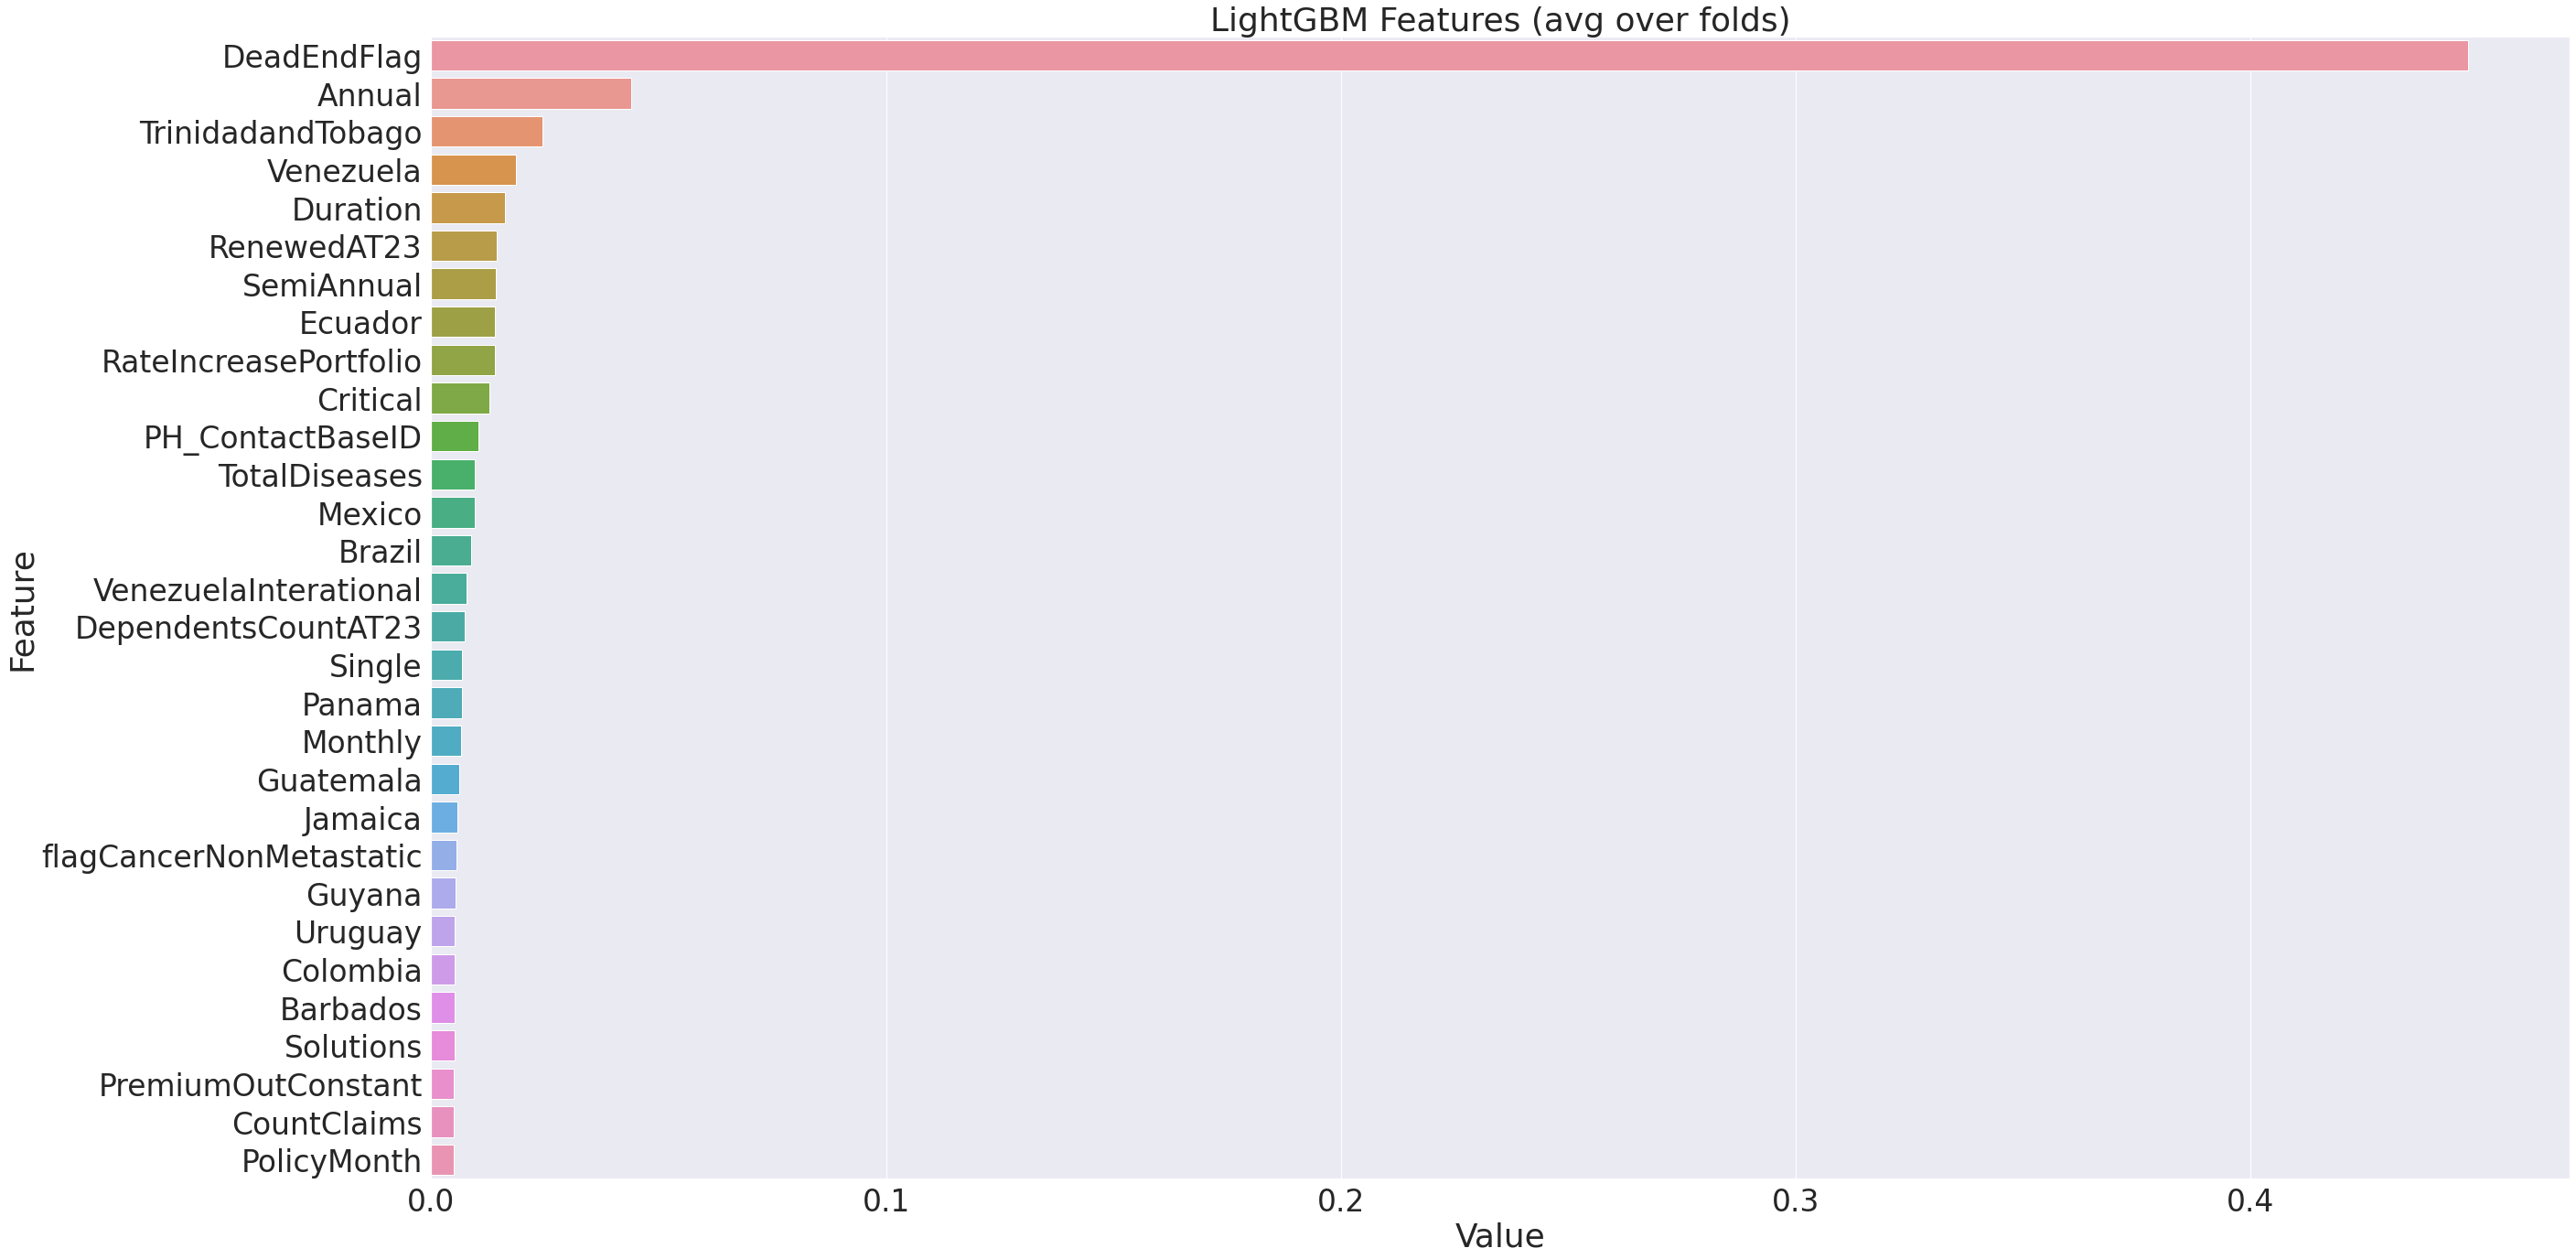

In [132]:
feat_rank = best_xgb.feature_importances_
#feat_rank = gbm.feature_importance()
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame({'Value':feat_rank,'Feature':X_train.columns})

plt.figure(figsize=(40, 20))
sns.set(font_scale = 3)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:30])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances-01.png')
plt.show()

In [169]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    
    cm_norm = np.round(cm.astype(float) / cm.sum(axis=0)*100, 2)

    title_fontsize = 20
    ann_fontsize = 14
    axis_fontsize = 16
    labels_fontsize = 18
    
    plt.rcParams.update({'font.size': ann_fontsize})
    plt.rcParams.update({'font.family':'sans-serif'})
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap='Reds')
    #plt.title(title, fontsize=title_fontsize)
    tick_marks = np.arange(len(classes))
    N_neg, N_pos = cm.sum(axis=0)
    plt.xticks(tick_marks, [f'{classes[0]}\n_______\n{N_neg}', f'{classes[1]}\n_______\n{N_pos}'], rotation=0, fontsize=axis_fontsize, weight='bold')
    plt.yticks(tick_marks, classes, fontsize=axis_fontsize, weight='bold')
    #plt.colorbar()
    thresh = cm.max() / 2.

    group_names = np.array([['True Neg','False Pos'],['False Neg','True Pos']])
    n,m = cm.shape
    for i, j in itertools.product(range(n), range(m)):
        plt.text(j, i, f'{group_names[i,j]} \n{cm[i,j]} \n{cm_norm[i,j]}%', horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()    
    plt.grid(False)
    plt.ylabel('Prediction', fontsize=labels_fontsize)
    plt.xlabel('True Value', fontsize=labels_fontsize)

Matriz de confusión para el conjunto de testeo


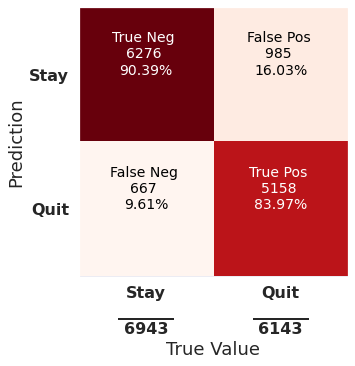

In [174]:
import itertools
from sklearn.metrics import confusion_matrix

class_names = np.array(['Stay', 'Quit'])

print("Matriz de confusión para el conjunto de testeo")
# Compute Testing confusion matrix
cnf_matrix = confusion_matrix(predxbg_test, y_test)
#np.set_printoptions(precision=2)
# Plot matriz de confusion sin normalizar
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Matriz de confusion sin normalizar')